In [1]:
import pandas
import math
import json
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

In [2]:
contents = pandas.read_csv('out.csv')

In [3]:
allowed_algos = ['humans', 'azure', 'histogram', 'google']

In [4]:
import matplotlib.pyplot as plt

In [5]:
def add_to_dict(dic, val):
    if val not in dic.keys():
        dic[val] = 1
    else:
        dic[val] += 1

In [15]:
all_ages = {}
all_gender = {}
all_educations = {}

for row in contents.iterrows():
    row_data = row[1]['datastring']
    if isinstance(row_data,str):
        json_data = json.loads(row_data)
        add_to_dict(all_ages, json_data['questiondata']['age'])
        add_to_dict(all_gender,json_data['questiondata']['gender'])
        add_to_dict(all_educations,json_data['questiondata']['education'])

In [16]:
all_ages_ = {}
all_ages_['30-40'] = all_ages['31-35']+all_ages['36-40']
all_ages_['<30'] = all_ages['26-30']
all_ages_['>40'] = all_ages['41-45']+all_ages['45-50']

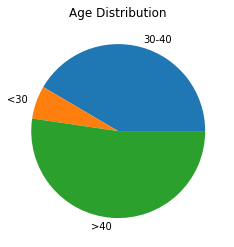

In [17]:
plt.pie(all_ages_.values(), labels = all_ages_.keys())
plt.title('Age Distribution')
plt.show() 

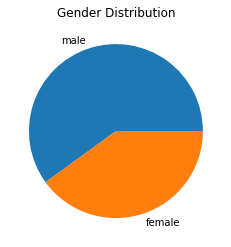

In [18]:
plt.pie(all_gender.values(), labels = all_gender.keys())
plt.title('Gender Distribution')
plt.show() 

In [24]:
all_educations_ = {}
all_educations_['Below Bachelors'] = all_educations['high school'] + all_educations['middle school']
all_educations_['Bachelors'] = all_educations['bachelor']
all_educations_['Above Bachelors'] = all_educations['master']

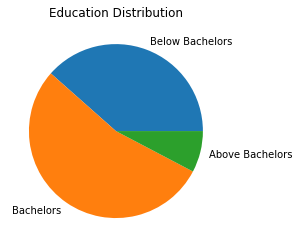

In [25]:
plt.pie(all_educations_.values(), labels = all_educations_.keys())
plt.title('Education Distribution')
plt.show() 

In [4]:
# for row in contents.iterrows():
#     row_data = row[1]['datastring']
#     if isinstance(row_data,str):
#         json_data = json.loads(row_data)
#         person_id = json_data['workerId']
#         person_questionnaire = json_data['questiondata']
#         person_df = pandas.DataFrame(columns = ['image','topic_match','response_class','actual_class','class_match','response_gender'])
#         for i in range(1,26):
#             ques_output = {}
#             ques_response = json_data['data'][i]['trialdata']
#             image = ques_response['imageID']
#             topic_match = int(ques_response['topic']) == int(ques_response['oneWord_curr']) + 1

#             response_class = ques_response['Aclass']
#             actual_class = page_to_class[ques_response['page_name'].split('_')[1]]
#             class_match = response_class == actual_class

#             response_gender = ques_response['Agender']
#             algo = page_to_algo[ques_response['page_name'].split('_')[1]]
#             if algo in allowed_algos:
#                 person_df = person_df.append({'image' : image, 'topic_match' : topic_match, 'response_class' : response_class,'actual_class':actual_class, 'class_match':class_match, 'response_gender': response_gender},ignore_index = True)

In [5]:
# person_questionnaire

In [6]:
# person_df

In [7]:
page_to_class = {}
page_to_class['a'] = 'H'
page_to_class['b'] = 'AI'
page_to_class['c'] = 'AI'
page_to_class['d'] = 'AI'


page_to_algo = {}
page_to_algo['a'] = 'humans'
page_to_algo['b'] = 'azure'
page_to_algo['c'] = 'histogram'
page_to_algo['d'] = 'google'

In [8]:
page_to_algo.values()

dict_values(['humans', 'azure', 'histogram', 'google'])

In [9]:
def parse_all_data(contents,allowed_algos = ['humans', 'azure', 'histogram', 'google']):
    person_to_personal_df = {}   
    for row in contents.iterrows():
        row_data = row[1]['datastring']
        if isinstance(row_data,str):
            json_data = json.loads(row_data)
            person_id = json_data['workerId']
            person_questionnaire = json_data['questiondata']
            person_df = pandas.DataFrame(columns = ['image','topic_match','response_class','actual_class','class_match','response_gender'])
            for i in range(1,26):
                ques_output = {}
                ques_response = json_data['data'][i]['trialdata']
                image = ques_response['imageID']
                topic_match = int(ques_response['topic']) == int(ques_response['oneWord_curr']) + 1
                
                response_class = ques_response['Aclass']
                actual_class = page_to_class[ques_response['page_name'].split('_')[1]]
                class_match = response_class == actual_class

                response_gender = ques_response['Agender']
                algo = page_to_algo[ques_response['page_name'].split('_')[1]]
                if algo in allowed_algos:
                    person_df = person_df.append({'image' : image, 'topic_match' : topic_match, 'response_class' : response_class,'actual_class':actual_class, 'class_match':class_match, 'response_gender': response_gender},ignore_index = True)
            person_to_personal_df[person_id] = person_df
    return person_to_personal_df

In [17]:
def run_analysis(person_to_personal_df,algos='all'):
    prediction_accs = []
    topic_accs = []
    all_actuals = []
    all_response_classes = []
    all_genders = []

    for person_id in person_to_personal_df.keys():
        person_df = person_to_personal_df[person_id]
        all_actuals.extend(list(person_df['actual_class']))
        all_response_classes.extend(list(person_df['response_class']))
        all_genders.extend(list(person_df['response_gender']))

        topic_accuracy = np.sum(person_df['topic_match'])/len(person_df['topic_match'])
        prediction_accuracy = np.sum(person_df['class_match'])/len(person_df['class_match'])
        topic_accs.append(topic_accuracy)
        prediction_accs.append(prediction_accuracy)
    print('Mean Topic Prediction:%s'%np.mean(topic_accs))
    print('Mean AI/H Prediction:%s'%np.mean(prediction_accs))
    print('Female prediction rate:%s'%(all_genders.count('F')/len(all_genders)))
    
    h_h = 0
    h_ai = 0
    ai_h = 0
    ai_ai = 0
    for i in range(len(all_actuals)):
        if all_actuals[i] == 'H':
            if all_response_classes[i] == 'H':
                h_h += 1
            if all_response_classes[i] == 'AI':
                h_ai += 1
        if all_actuals[i] == 'AI':
            if all_response_classes[i] == 'H':
                ai_h += 1
            if all_response_classes[i] == 'AI':
                ai_ai += 1
    confusion_df = pandas.DataFrame([[h_h/(h_h+h_ai), h_ai/(h_h+h_ai)], [ai_h/(ai_h+ai_ai), ai_ai/(ai_h+ai_ai)]], columns=['H','AI'], index=['H', 'AI'])
    print(confusion_df)
    return np.mean(prediction_accs),confusion_df 

# Humans vs All

In [18]:
means = {}
dfs = {}

In [19]:
parsed_data = parse_all_data(contents)
means['all'], dfs['all'] = run_analysis(parsed_data)

Mean Topic Prediction:0.8713846153846154
Mean AI/H Prediction:0.5796923076923077
Female prediction rate:0.39076923076923076
           H        AI
H   0.552239  0.447761
AI  0.393423  0.606577


# Humans vs Azure

In [20]:
parsed_data = parse_all_data(contents,['humans','azure'])
means['azure'], dfs['azure'] = run_analysis(parsed_data)

Mean Topic Prediction:0.8690179124413466
Mean AI/H Prediction:0.5629368502683578
Female prediction rate:0.3854166666666667
           H        AI
H   0.552239  0.447761
AI  0.404762  0.595238


# Humans vs Histogram

In [25]:
parsed_data = parse_all_data(contents,['humans','histogram'])
means['histogram'], dfs['histogram'] = run_analysis(parsed_data)

Mean Topic Prediction:0.8694094232353341
Mean AI/H Prediction:0.5793395930892955
Female prediction rate:0.39575645756457567
           H        AI
H   0.552239  0.447761
AI  0.346429  0.653571


# Humans vs Google

In [26]:
parsed_data = parse_all_data(contents,['humans','google'])
means['google'], dfs['google'] = run_analysis(parsed_data)

Mean Topic Prediction:0.8650014321102676
Mean AI/H Prediction:0.5567340741209519
Female prediction rate:0.42360475754803295
           H        AI
H   0.552239  0.447761
AI  0.429066  0.570934


# Plotting

In [27]:
result_conf_mat = np.zeros((5,2))
result_conf_mat[0] = np.array(dfs['all'])[0]
result_conf_mat[1] = np.array(dfs['all'])[1]
result_conf_mat[2] = np.array(dfs['azure'])[1]
result_conf_mat[3] = np.array(dfs['histogram'])[1]
result_conf_mat[4] = np.array(dfs['google'])[1]

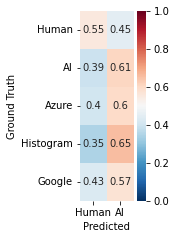

In [33]:
modelist = ['Azure','Histogram','Google']

plotname = 'dominant_color_recognition'

import os
os.makedirs('figures',exist_ok=True)

#plot confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(result_conf_mat, index = [i for i in ['Human','AI']+modelist],
                  columns = [i for i in ['Human','AI']])
plt.figure(figsize = (1.2,3.5))
sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.savefig('figures/' + plotname + '_confmat.pdf', bbox_inches='tight')
plt.show()

[[0.55223881 0.44776119]
 [0.39342266 0.60657734]
 [0.4047619  0.5952381 ]
 [0.34642857 0.65357143]
 [0.42906574 0.57093426]]
[0.5794080753358664, 0.5737384506041223, 0.6029051172707889, 0.5615865310127564]


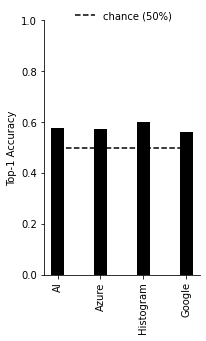

In [34]:
#compute top 1 accuracy for each AI model and also overall AI
top1 = []
print(result_conf_mat)
for i in range(1+len(modelist)):
    #print(i)
    top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
print(top1)

import matplotlib.pyplot as plt
import numpy as np
 
#data
#x-axis
years = list(range(1, 2+len(modelist)))
strtask = ['AI'] + modelist
#print(years)
#print(strtask)

# Figure Size
fig, ax = plt.subplots()

#bar chart properties
ax.bar(strtask, top1, color ='black', width = 0.3)
  
plt.ylabel('Top-1 Accuracy')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

plt.ylim(0, 1)
#plt.xlim(0.5, len(years)+0.5)

#draw chance 0.5 
chancex =np.arange(len(years))
plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
#plt.legend()
 
fig.tight_layout()

fig.set_figwidth(2.5)
fig.set_figheight(5)

fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
fig.savefig('figures/' + plotname + '.pdf', bbox_inches='tight')